In [1]:
import sys
sys.path.append("/Users/danmohad/Documents/Stanford/Courses/Year 5/CS230/project/nn_physical_concepts")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scinet import *
import scinet.ed_oscillator as edo
from sklearn.feature_selection import mutual_info_regression

### Helper functions for plots

In [2]:
def osc_eqn(A_0, delta_0, b, kappa, t):
    return np.real(A_0 * np.exp(-b / 2. * t) * np.exp(1 / 2. * np.sqrt(b**2 - 4 * kappa + 0.j) * t + 1.j * delta_0))

def gen_input(A_0, delta_0, b, kappa, tt_predicted):
    tt_in = np.linspace(0, 5, 50)
    in1 = np.array([osc_eqn(A_0, delta_0, b, kappa, tt_in) for _ in tt_predicted])
    in2 = np.reshape(tt_predicted, (-1, 1))
    out = in2 #dummy filler
    return [in1, in2, out]

In [3]:
blue_color='#000cff'
orange_color='#ff7700'

In [4]:
def pendulum_prediction(net, b, kappa):    
    tt_given = np.linspace(0, 10, 250)
    tt_predicted = np.linspace(0, 10, 250)
    a_given = osc_eqn(1, 0, b, kappa, tt_given)
    a_precicted = net.run(gen_input(1, 0, b, kappa, tt_predicted), net.output).ravel()
    fig = plt.figure(figsize=(3.4, 2.1))
    ax = fig.add_subplot(111)
    ax.plot(tt_given, a_given, color=orange_color, label='True time evolution')
    ax.plot(tt_predicted, a_precicted, '--', color=blue_color, label='Predicted time evolution')
    ax.set_xlabel(r'$t$ [$s$]')
    ax.set_ylabel(r'$x$ [$m$]')
    handles, labels = ax.get_legend_handles_labels()
    lgd=ax.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.6, 1.3), shadow=True, ncol=1)
    fig.tight_layout()
    return fig

In [5]:
def osc_representation_plot(net, b_range, kappa_range, step_num=100, eval_time=7.5):
    bb = np.linspace(*b_range, num=step_num)
    kk = np.linspace(*kappa_range, num=step_num)
    B, K = np.meshgrid(bb, kk)
    out = np.array([net.run(gen_input(1, 0, b, kappa, [eval_time]), net.mu)[0] for b, kappa in zip(np.ravel(B), np.ravel(K))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot('1{}{}'.format(net.latent_size, i + 1), projection='3d')
        Z = np.reshape(zs, B.shape)
        surf = ax.plot_surface(B, K, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$b$ [$kg/s$]')
        ax.set_ylabel(r'$\kappa$ [$kg/s^2$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) #Fix the scale for the third plot, where the activation is close to zero
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

## Load pre-trained model

### Parameters
- `latent_size: 2` 
- `input_size: 50`
- `input2_size: 1`
- `output_size: 1`
- `encoder_num_units: [500, 100]`
- other parameters: default values
### Data
- Only kappa and b are varied (in the default intervals), A_0 and delta_0 are fixed
- `t_sample: np.linspace(0, 5, 50)` (fed into the network)
- `t_meas_interval: (0, 10)` (time interval in which prediction times lie)
- training data: 95000 samples
- validation data: 5000 samples

### Training
- `epoch_num: 1000`, `batch_size: 512`, `learning_rate: 1e-3`, `beta: 1e-3`

In [6]:
net_2_latent = nn.Network.from_saved('oscillator')

{'decoder_num_units': [100, 100], 'input2_size': 1, 'tot_epochs': 1000, 'latent_size': 2, 'output_size': 1, 'encoder_num_units': [500, 100], 'input_size': 50, 'load_file': 'oscillator', 'name': 'oscin2_5'}







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








INFO:tensorflow:Restoring parameters from /Users/danmohad/Documents/Stanford/Courses/Year 5/CS230/project/nn_physical_concepts/tf_save/oscillator.ckpt
Loaded network from file oscillator


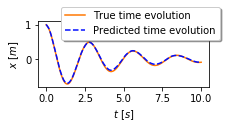

In [7]:
pendulum_prediction(net_2_latent, 0.5, 5.);

In [8]:
%matplotlib tk
osc_representation_plot(net_2_latent, [0.5, 1], [5, 10]);

## Load pre-trained model

### Parameters
- `latent_size: 3` 
- Rest as for `net_2_latent`

In [ ]:
net_3_latent = nn.Network.from_saved('oscillator_3_latent')

In [ ]:
pendulum_prediction(net_3_latent, 0.5, 5.);

In [ ]:
%matplotlib tk
osc_representation_plot(net_3_latent, [0.5, 1], [5, 10]);

## Calculate L2 norm of error

In [ ]:
data, states, params = edo.oscillator_data(50000, t_meas_interval=(0, 10))

In [ ]:
np.sqrt(net_3_latent.run(data, net_3_latent.recon_loss))

## Calculate mutual information between latent neurons

In [ ]:
data, states, params = edo.oscillator_data(200000, t_meas_interval=(0, 10))

In [ ]:
# Calculate the mutual information between two latent neurons
def mi(net, data, latent_neuron_1, latent_neuron_2):
    mu = net_3_latent.run(data, net_3_latent.mu)
    mi_estimate = mutual_info_regression(mu[:,latent_neuron_1].reshape(-1, 1), mu[:,latent_neuron_2], discrete_features = False)
    return mi_estimate[0]

In [ ]:
mi(net_3_latent, data, 0, 0)

In [ ]:
mi(net_3_latent, data, 0, 1)